In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl
# %matplotlib qt
import sys
sys.path.append('C:\code\qdc2')
import matplotlib.pyplot as plt 
import os 
import numpy as np 
from qdc.mmf.many_wl_fiber import ManyWavelengthFiber
from qdc.mmf.qdc_experiment import QDCMMFExperiment
from qdc.misc import tnow
DATA_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, '..', 'data')))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MMF

In [2]:
def run_mmf(is_step_index=False):
    fiber_L = 0.1e6  if is_step_index else 2e6 # um 
    N_wl = 81
    N_classical = 5
    N_SPDC = 5
    wl0 = 0.810
    Dwl = 0.020 if is_step_index else 0.020
    NA_ref = 0.2   
    dzs = [0, 10, 50, 200, 1000] if is_step_index else [0, 10, 50, 80]
    free_mode_matrix = True  # when working with 2**8, the RAM explodes 
    autosolve = not free_mode_matrix  # if freeing each time - no point in autosolving initially 

    npoints = 2**8
    n_pixels_diameter = 2*npoints//5 if is_step_index else npoints//4
    s = ManyWavelengthFiber(wl0=wl0, Dwl=Dwl, N_wl=N_wl, fiber_L=fiber_L, rng_seed=5555, is_step_index=is_step_index, 
                            npoints=npoints, NA_ref=NA_ref, autosolve=autosolve)
    s.gaussian_params = np.array([2.7, 7, 10, 0.5, 0.5]) 
    s.gaussian_dparams = np.array([1, 5, 5, 0.3, 0.3])
    # s.gaussian_dparams = np.array([0, 4, 4, 0.1, 0.1])

    exp = QDCMMFExperiment(s, free_mode_matrix=free_mode_matrix)
    exp._set_PCC_slice(n_pixels_diameter=n_pixels_diameter)
    res = exp.run_PCCs_different_dz(dzs=dzs, N_classical=N_classical, N_SPDC=N_SPDC)

    f_type = 'SI' if is_step_index else 'GRIN'
    saveto_path = rf'{DATA_DIR}\\{tnow()}_{f_type}_{round(fiber_L*1e-6, 2)}m_N=100.npz'
    res.saveto(saveto_path)
    return res

res_SI = run_mmf(is_step_index=False)
res_GRIN = run_mmf(is_step_index=True)

Getting 81 fibers...


81it [00:04, 18.92it/s]


Got fibers!
Getting classical with average on 5 ...


Running classical measurements: 100%|██████████| 5/5 [05:14<00:00, 62.88s/it]


Getting SPDC with average on 5, dz=0 ...


Running SPDC measurements: 100%|██████████| 5/5 [09:24<00:00, 112.82s/it]


Getting SPDC with average on 5, dz=10 ...


Running SPDC measurements: 100%|██████████| 5/5 [09:38<00:00, 115.67s/it]


Getting SPDC with average on 5, dz=50 ...


Running SPDC measurements: 100%|██████████| 5/5 [09:43<00:00, 116.66s/it]


Getting SPDC with average on 5, dz=80 ...


Running SPDC measurements: 100%|██████████| 5/5 [09:14<00:00, 110.98s/it]


Getting 81 fibers...


81it [00:01, 65.46it/s]


Got fibers!
Getting classical with average on 5 ...


Running classical measurements: 100%|██████████| 5/5 [11:16<00:00, 135.23s/it]


Getting SPDC with average on 5, dz=0 ...


Running SPDC measurements: 100%|██████████| 5/5 [22:13<00:00, 266.62s/it]


Getting SPDC with average on 5, dz=10 ...


Running SPDC measurements: 100%|██████████| 5/5 [21:02<00:00, 252.46s/it]


Getting SPDC with average on 5, dz=50 ...


Running SPDC measurements: 100%|██████████| 5/5 [20:51<00:00, 250.32s/it]


Getting SPDC with average on 5, dz=200 ...


Running SPDC measurements: 100%|██████████| 5/5 [20:50<00:00, 250.04s/it]


Getting SPDC with average on 5, dz=1000 ...


Running SPDC measurements: 100%|██████████| 5/5 [20:58<00:00, 251.63s/it]


## View results 

In [ ]:
res = res_SI
iter_no = None
dz = 0
print(res.metadata["g_params_list"][iter_no or 0])
res.show(title='', iter_no=iter_no, show0=False)
# for i in range(5):
    # res.show_incoherent_sum(iter_no=i, dz=dz)
    # res.show(title='', iter_no=i, show0=False)

res.show_incoherent_sum(iter_no=iter_no, dz=dz)

## View input and output fields + mode distribution for given gaussian params 

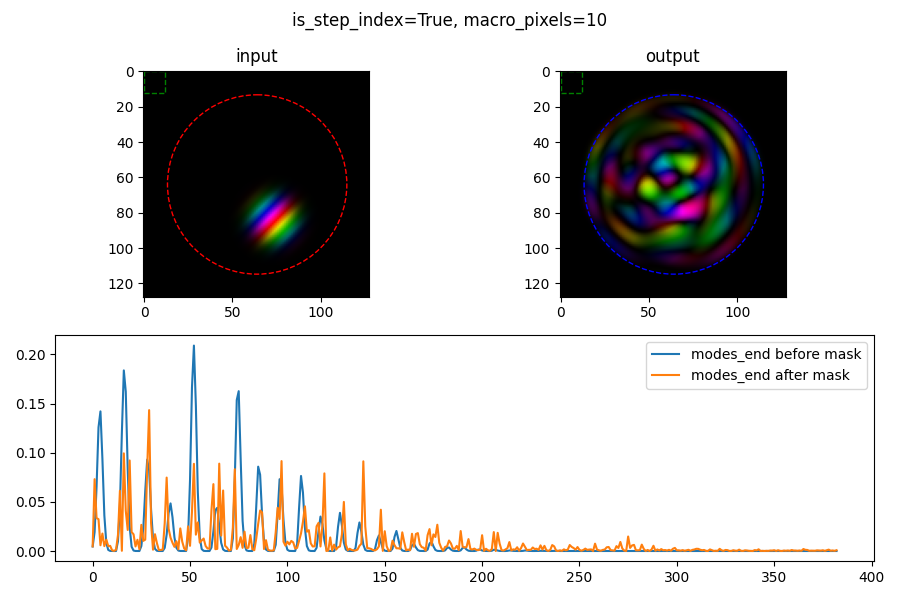

In [5]:
import cv2
from qdc.mmf.fiber import Fiber

is_step_index = True
f = Fiber(is_step_index=is_step_index)
f.set_input_gaussian(sigma=3, X0=5, Y0=10, X_linphase=0.4, Y_linphase=0.4, random_phase=0.0)
f.propagate(False)

fig, axes = plt.subplot_mosaic(
    [["left", "right"],
     ["bottom", "bottom"]],
    figsize=(9, 6)
)

from matplotlib import patches
# make circle centered in the middle of the plot
circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='red', fill=False, linestyle='dashed')
axes["left"].add_patch(circle)
circle = patches.Circle((f.npoints//2, f.npoints//2), 25/f.index_profile.dh, color='blue', fill=False, linestyle='dashed')
axes["right"].add_patch(circle)


f.show_profile(f.profile_0,   ax=axes["left"],   title='input')
f.show_profile(f.profile_end, ax=axes["right"],  title='output')

# axes["bottom"].plot(np.abs(f.modes_0)**2, label='modes 0')
axes["bottom"].plot(np.abs(f.modes_0)**2, label='modes_end before mask')

macro_pixels = 10
square_size = f.npoints//macro_pixels
square = patches.Rectangle((0,0), square_size, square_size, color='green', fill=False, linestyle='dashed')
axes["left"].add_patch(square)
square = patches.Rectangle((0,0), square_size, square_size, color='green', fill=False, linestyle='dashed')
axes["right"].add_patch(square)

A = np.random.uniform(0, 2*np.pi, size=(macro_pixels, macro_pixels))
A = cv2.resize(A, (f.npoints.item(), f.npoints.item()), interpolation=cv2.INTER_AREA)
A = np.exp(1j*A)
profile_after_mask = f.profile_end * A.ravel()
modes_after_mask = f.modes.getModeMatrix().T @ profile_after_mask

axes["bottom"].plot(np.abs(modes_after_mask)**2, label='modes_end after mask')

axes["bottom"].legend()
fig.suptitle(f'is_step_index={is_step_index}, macro_pixels={macro_pixels}')
plt.tight_layout()

Getting 3 fibers...


3it [00:01,  2.34it/s]


Got fibers!
Getting 3 fibers...


3it [00:01,  2.31it/s]


Got fibers!


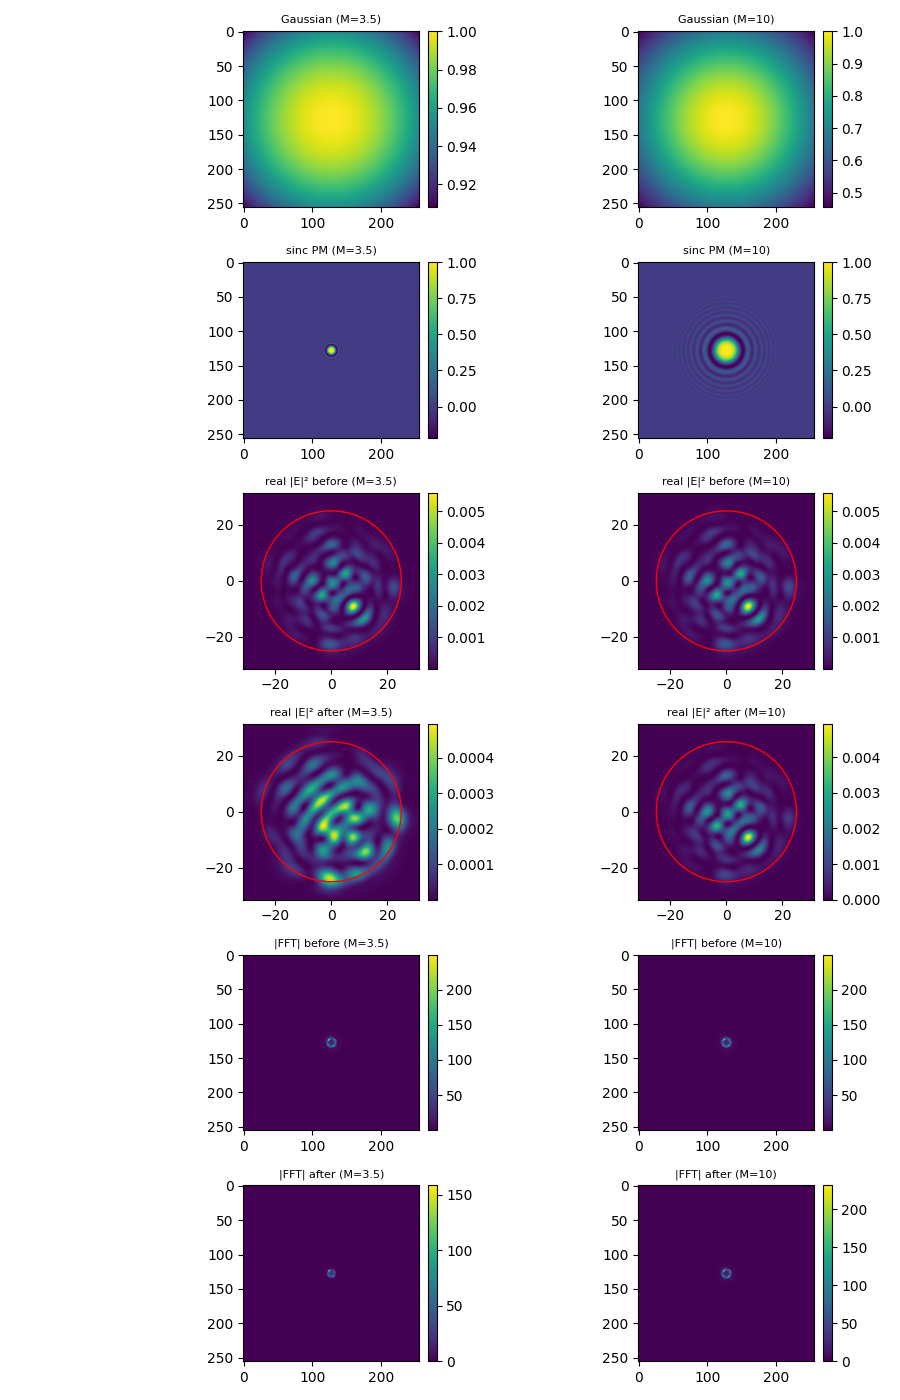

In [20]:
# quick_pm_compare_M.py  (colorbar & after-field version)
import numpy as np, matplotlib.pyplot as plt
from qdc.mmf.many_wl_fiber import ManyWavelengthFiber
from qdc.mmf.qdc_experiment import QDCMMFExperiment, propagate_free_space

def make_exp(M, is_step_index=False):
    mwf = ManyWavelengthFiber(N_wl=3, npoints=256, is_step_index=is_step_index)
    exp = QDCMMFExperiment(mwf)
    exp.set_phase_matching(Lc_um=2000, pump_waist_crystal=500,
                           magnification=M, wl_pump=0.405, n_pump=1.692)
    return mwf, exp

def run_and_collect(M, is_step_index=False):
    mwf, exp = make_exp(M, is_step_index)
    mid = len(mwf.fibers) // 2
    f = mwf.fibers[mid]
    f.set_input_gaussian(*exp.g_params)

    E0 = f.propagate(show=False)
    E_half = propagate_free_space(E0, 40, f.wl, mwf.dx)
    E_filt = exp._apply_phase_matching(E_half)

    n = exp.n
    G = exp._pm_pump_amp if exp._pm_pump_amp is not None else np.ones((n, n))
    S = np.fft.fftshift(exp._pm_filter)

    F0 = np.abs(np.fft.fftshift(np.fft.fft2(E_half.reshape(n, n))))
    F1 = np.abs(np.fft.fftshift(np.fft.fft2(E_filt.reshape(n, n))))
    I0 = np.abs(E_half.reshape(n, n)) ** 2
    I1 = np.abs(E_filt.reshape(n, n)) ** 2
    return dict(G=G, S=S, I0=I0, I1=I1, F0=F0, F1=F1, dx=mwf.dx)

# -------- plot helper with colorbar --------
def show(ax, img, ttl, dx=None, fiber_radius_um=None):
    extent = None
    if dx is not None:
        n = img.shape[0]
        extent = [-(n // 2) * dx, (n // 2) * dx,
                  -(n // 2) * dx, (n // 2) * dx]

    im = ax.imshow(img, extent=extent)
    ax.set_title(ttl, fontsize=8)
    # ax.axis('off')
    plt.colorbar(im, ax=ax, fraction=0.045, pad=0.02)

    # Add fiber core circle in real space
    if fiber_radius_um is not None and dx is not None:
        from matplotlib.patches import Circle
        circle = Circle((0, 0), radius=fiber_radius_um, edgecolor='red',
                        facecolor='none', lw=1)
        ax.add_patch(circle)

Ms = [3.5, 10]
is_step_index = True
data1 = run_and_collect(M=Ms[0], is_step_index=is_step_index)
data2 = run_and_collect(M=Ms[1], is_step_index=is_step_index)

titles = ['Gaussian', 'sinc PM', 'real |E|² before', 'real |E|² after',
          '|FFT| before', '|FFT| after']
rows = ['G', 'S', 'I0', 'I1', 'F0', 'F1']

fig, axes = plt.subplots(len(rows), 2, figsize=(9, 14))
for col, data, M in zip([0, 1], [data1, data2], Ms):
    dx = data['dx']
    for r, key in enumerate(rows):
        is_real_space = key in ['I0', 'I1']
        show(axes[r, col], data[key], f'{titles[r]} (M={M})',
             dx=dx if is_real_space else None,
             fiber_radius_um=25 if is_real_space else None)

plt.tight_layout()
plt.show()
